### Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.externals import joblib

%matplotlib inline

In [205]:
import numpy as np

### Set Up

In [206]:
# Full path of the 'orders' dataset
orders_file = 'https://www.dropbox.com/s/ej64qorm1uvmjlp/olist_orders_dataset.csv?dl=1'

# Full path of the 'customer' dataset
cust_file = 'https://www.dropbox.com/s/t082qlggu4wxiq5/olist_customers_dataset.csv?dl=1'

# File output location
out = r"C:\Users\lemcd\OneDrive\Documents\0VCU DAPT\Python"

### Read Data

In [207]:
    # Read the orders data
    orders = pd.read_csv(orders_file)

    print (f'{len(orders):,d} read from the orders file.')
    # Drop unnecessary columns
    drop_vars = ['order_delivered_carrier_date']

    orders = orders.drop(drop_vars, axis=1)

    # Date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

    # Convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date

    # Extract month from the order date
    orders['order_month'] = orders['order_purchase_timestamp'].dt.month

    # Read the file that contains the unique customer identifier
    cust = pd.read_csv(cust_file)

    print (f'{len(cust):,d} read from the customer file.')

    # Keep only the following two columns: customer_id, customer_unique_id
    cust = cust[['customer_id', 'customer_unique_id']]

    # Merge orders and cust dataframes
    orders = pd.merge(orders, cust, on='customer_id', how='inner')
    
    print (f'{len(orders):,d} records in the output  file.')
    

99,441 read from the orders file.
99,441 read from the customer file.
99,441 records in the output  file.


In [208]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,order_month,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02,10,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24,7,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-08,8,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-18,11,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-13,2,72632f0f9dd73dfee390c9b22eb56dd6


In [209]:
# Extract the weekday from the order date timestamp (order_purchase_timestamp)
# Is there any seasonality in order volume by weekday?

In [210]:
orders['order_dow'] = orders['order_purchase_timestamp'].dt.weekday

In [211]:
orders.order_dow.value_counts(sort=False)

0    16196
1    15963
2    15552
3    14761
4    14122
5    10887
6    11960
Name: order_dow, dtype: int64

In [212]:
orders['order_year'] = orders['order_purchase_timestamp'].dt.year
orders.groupby(['order_year', 'order_dow'])['order_id'].count()

order_year  order_dow
2016        0              48
            1              64
            2              47
            3              52
            4              47
            5              43
            6              28
2017        0            7188
            1            7170
            2            6775
            3            6516
            4            6915
            5            5051
            6            5486
2018        0            8960
            1            8729
            2            8730
            3            8193
            4            7160
            5            5793
            6            6446
Name: order_id, dtype: int64

In [213]:
orders.groupby(['order_year', 'order_dow'])['order_id'].count().reset_index().head()

,order_year,order_dow,order_id
0,2016,0,48
1,2016,1,64
2,2016,2,47
3,2016,3,52
4,2016,4,47


In [214]:
order_counts_by_dow_by_year = orders.groupby(['order_year', 'order_dow'])['order_id'].count().reset_index()

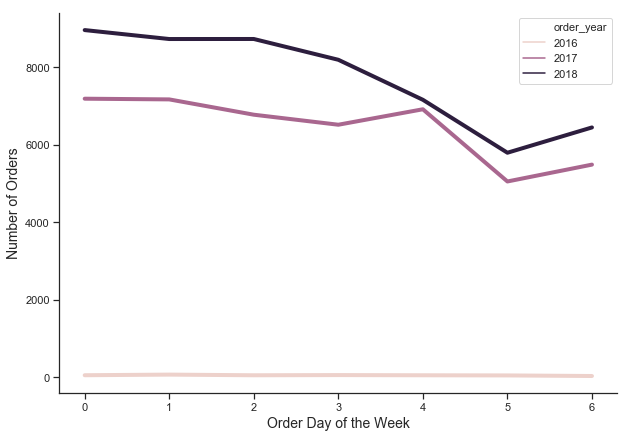

In [215]:
sns.set(style='ticks')

plt.figure(figsize=[10, 7])

sns.lineplot(x='order_dow', y='order_id', lw=4, hue='order_year', data=order_counts_by_dow_by_year)

plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('Order Day of the Week', fontsize=14)

sns.despine()

#### Question 1:
Are there any specific days of the week that have a higher order volume as compared to others?
There is higher order volume on Monday, Tuesday and Wednesday, then order volume drops off through Saturday, then starts to lift again on Sunday.
Is the pattern consistent across the years?
This pattern began in 2017 and has been mostly consistent in 2018. There was a slight lift on Fridays in 2017 but that pattern did not continue in 2018.

#### Question 2: 
Recreate the two attributes, order_recency and total_orders, using March 2018 as the prediction window.

In [216]:
snapshot_date = date(2018, 2, 28)

# added ".copy()" to this piece so I could manipulate data type of timestamps later
attr_raw = orders[orders['order_purchase_timestamp'].dt.date <= snapshot_date].copy()

len(orders), len(attr_raw)

(99441, 59427)

In [217]:
attr_raw.order_purchase_timestamp.max()

Timestamp('2018-02-28 23:57:55')

In [218]:
order_recency = attr_raw.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

order_recency.head()

,customer_unique_id,order_purchase_timestamp
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
3,00053a61a98854899e70ed204dd4bafe,2018-02-28 11:15:41
4,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12


In [219]:
delta = snapshot_date - order_recency['order_purchase_timestamp'].dt.date

delta.head()

0   355 days
1   139 days
2   106 days
3     0 days
4   361 days
Name: order_purchase_timestamp, dtype: timedelta64[ns]

In [220]:
order_recency['order_recency_days'] = delta.dt.days

order_recency.head()

,customer_unique_id,order_purchase_timestamp,order_recency_days
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,355
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,139
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,106
3,00053a61a98854899e70ed204dd4bafe,2018-02-28 11:15:41,0
4,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,361


In [221]:
cust_recency = order_recency.drop('order_purchase_timestamp', axis=1)

In [222]:
len(cust_recency)

57510

In [223]:
cust_recency.head()

,customer_unique_id,order_recency_days
0,0000f46a3911fa3c0805444483337064,355
1,0000f6ccb0745a6a4b88665a16c9f078,139
2,0004aac84e0df4da2b147fca70cf8255,106
3,00053a61a98854899e70ed204dd4bafe,0
4,0005e1862207bf6ccc02e4228effd9a0,361


In [224]:
# Count total records (i.e., orders) per customer

cust_orders = attr_raw.groupby('customer_unique_id').size().reset_index()

cust_orders.head()

,customer_unique_id,0
0,0000f46a3911fa3c0805444483337064,1
1,0000f6ccb0745a6a4b88665a16c9f078,1
2,0004aac84e0df4da2b147fca70cf8255,1
3,00053a61a98854899e70ed204dd4bafe,1
4,0005e1862207bf6ccc02e4228effd9a0,1


In [225]:
cust_orders = cust_orders.rename(columns={0: 'total_orders'})

In [226]:
attr = pd.merge(cust_recency, cust_orders, on='customer_unique_id', how='inner')

len(attr)

57510

In [227]:
attr.head()

,customer_unique_id,order_recency_days,total_orders
0,0000f46a3911fa3c0805444483337064,355,1
1,0000f6ccb0745a6a4b88665a16c9f078,139,1
2,0004aac84e0df4da2b147fca70cf8255,106,1
3,00053a61a98854899e70ed204dd4bafe,0,1
4,0005e1862207bf6ccc02e4228effd9a0,361,1


In [228]:
attr.total_orders.max()

10

#### Question 3: 
Create three additional attributes of your choice derived from the data available in the two files.

In [229]:
attr_raw.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,order_month,customer_unique_id,order_dow,order_year
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02,10,7c396fd4830fd04220f754e42b4e5bff,0,2017
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-18,11,7c142cf63193a1473d2e66489a9ae977,5,2017
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-13,2,72632f0f9dd73dfee390c9b22eb56dd6,1,2018
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-26 10:57:55,2017-08-01 00:00:00,2017-07-09,7,80bb27c7c16e8f973207a5086ab329e2,6,2017
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,2017-05-09 00:00:00,2017-04-11,4,36edbb3fb164b1f16485364b6fb04c73,1,2017


In [230]:
attr_raw['order_purchase_date'] = attr_raw['order_purchase_timestamp'].dt.date

In [231]:
# Convert other two dates for calculation to datetime format
attr_raw['order_delivered_customer_date'] = pd.to_datetime(attr_raw['order_delivered_customer_date'])
attr_raw['order_estimated_delivery_date'] = pd.to_datetime(attr_raw['order_estimated_delivery_date'])

In [232]:
# Drop time from datetime to return just the dates in new columns
attr_raw['order_delivered_date'] = attr_raw['order_delivered_customer_date'].dt.date
attr_raw['order_estimated_del_date'] = attr_raw['order_estimated_delivery_date'].dt.date

In [233]:
# Create new variable for delivery time from date of purchase to date of delivery
attr_raw['order_delivery_time'] = attr_raw['order_delivered_date'] - attr_raw['order_purchase_date']
attr_raw['order_delivery_days'] = attr_raw['order_delivery_time'].dt.days

In [234]:
# Create new variable for on time delivery metric 
attr_raw['order_delivered_to_estimate'] = attr_raw['order_delivered_date'] - attr_raw['order_estimated_del_date']
attr_raw['order_delivered_to_est_days'] = attr_raw['order_delivered_to_estimate'].dt.days

In [235]:
# Get the average delivery time per customer 
avg_deliv_time = attr_raw.groupby('customer_unique_id')['order_delivery_days'].mean().reset_index()

avg_deliv_time.head()

,customer_unique_id,order_delivery_days
0,0000f46a3911fa3c0805444483337064,26.0
1,0000f6ccb0745a6a4b88665a16c9f078,20.0
2,0004aac84e0df4da2b147fca70cf8255,13.0
3,00053a61a98854899e70ed204dd4bafe,16.0
4,0005e1862207bf6ccc02e4228effd9a0,5.0


In [236]:
len(avg_deliv_time)

57510

In [237]:
# Get the average on time delivery per customer
avg_otd = attr_raw.groupby('customer_unique_id')['order_delivered_to_est_days'].mean().reset_index()

avg_otd.head()

,customer_unique_id,order_delivered_to_est_days
0,0000f46a3911fa3c0805444483337064,-2.0
1,0000f6ccb0745a6a4b88665a16c9f078,-12.0
2,0004aac84e0df4da2b147fca70cf8255,-8.0
3,00053a61a98854899e70ed204dd4bafe,-10.0
4,0005e1862207bf6ccc02e4228effd9a0,-28.0


In [238]:
len(avg_otd)

57510

In [239]:
# Add two derived variables to data frame via inner join

attr_all = pd.merge(attr, avg_deliv_time, on='customer_unique_id', how='inner')
attr_all2 = pd.merge(attr_all, avg_otd, on='customer_unique_id', how='inner')

len(attr_all2)

57510

In [240]:
attr_all2.head()

,customer_unique_id,order_recency_days,total_orders,order_delivery_days,order_delivered_to_est_days
0,0000f46a3911fa3c0805444483337064,355,1,26.0,-2.0
1,0000f6ccb0745a6a4b88665a16c9f078,139,1,20.0,-12.0
2,0004aac84e0df4da2b147fca70cf8255,106,1,13.0,-8.0
3,00053a61a98854899e70ed204dd4bafe,0,1,16.0,-10.0
4,0005e1862207bf6ccc02e4228effd9a0,361,1,5.0,-28.0


#### Question 4:
Create the dependent variable, purch, using the following definition: did the customer make at least one purchase during the prediction window? If a customer did make a purchase within the prediction window, then set purch to 1, otherwise set it to 0.

In [241]:
# Select orders that were placed in March 2018

mask = (orders['order_purchase_timestamp'].dt.month == 3) & (orders['order_purchase_timestamp'].dt.year == 2018)

target_events_raw = orders[mask]

len(target_events_raw)

7211

In [242]:
# Confirm the min and max dates are within the month of March 2018

print (target_events_raw['order_purchase_timestamp'].min(), target_events_raw['order_purchase_timestamp'].max())

2018-03-01 00:00:00 2018-03-31 23:54:10


In [243]:
# Count the number of orders (we will convert this into a binary flag later)

target_events = target_events_raw.groupby('customer_unique_id').size().reset_index()

target_events.head()

,customer_unique_id,0
0,0005ef4cd20d2893f0d9fbd94d3c0d97,1
1,00090324bbad0e9342388303bb71ba0a,1
2,0010fb34b966d44409382af9e8fd5b77,1
3,0023557a94bef0038066b5d1b3dc763e,1
4,0027324a96d26a2bc7d69262f83c8403,1


In [244]:
len(target_events)

7115

In [245]:
# Merge the new dataframe (created above) with the dataframe that contains customer attributes

df = pd.merge(attr_all2, target_events, how='left', on='customer_unique_id')

df.head()

,customer_unique_id,order_recency_days,total_orders,order_delivery_days,order_delivered_to_est_days,0
0,0000f46a3911fa3c0805444483337064,355,1,26.0,-2.0,NaN
1,0000f6ccb0745a6a4b88665a16c9f078,139,1,20.0,-12.0,NaN
2,0004aac84e0df4da2b147fca70cf8255,106,1,13.0,-8.0,NaN
3,00053a61a98854899e70ed204dd4bafe,0,1,16.0,-10.0,NaN
4,0005e1862207bf6ccc02e4228effd9a0,361,1,5.0,-28.0,NaN


In [246]:
len(df)

57510

In [247]:
# Rename the target column

df = df.rename(columns={0: 'purch'})

df.shape

(57510, 6)

In [248]:
df.purch.value_counts()

1.0    145
2.0      5
Name: purch, dtype: int64

In [249]:
# Create the binary target flag

df['purch'] = [1 if x > 0 else 0 for x in df['purch']]

df.head()

,customer_unique_id,order_recency_days,total_orders,order_delivery_days,order_delivered_to_est_days,purch
0,0000f46a3911fa3c0805444483337064,355,1,26.0,-2.0,0
1,0000f6ccb0745a6a4b88665a16c9f078,139,1,20.0,-12.0,0
2,0004aac84e0df4da2b147fca70cf8255,106,1,13.0,-8.0,0
3,00053a61a98854899e70ed204dd4bafe,0,1,16.0,-10.0,0
4,0005e1862207bf6ccc02e4228effd9a0,361,1,5.0,-28.0,0


In [250]:
# Check the distribution of the target flag

df.purch.value_counts()

0    57360
1      150
Name: purch, dtype: int64

In [251]:
# % distribution of the target flag

df.purch.value_counts() / len(df)

0    0.997392
1    0.002608
Name: purch, dtype: float64

In [252]:
# Check the correlations

df[['order_recency_days', 'total_orders', 'order_delivery_days', 'order_delivered_to_est_days', 'purch']].corr()

,order_recency_days,total_orders,order_delivery_days,order_delivered_to_est_days,purch
order_recency_days,1.000000,-0.027407,-0.100910,-0.201047,-0.016843
total_orders,-0.027407,1.000000,-0.010749,-0.015612,0.038106
order_delivery_days,-0.100910,-0.010749,1.000000,0.700477,-0.001334
order_delivered_to_est_days,-0.201047,-0.015612,0.700477,1.000000,-0.002814
purch,-0.016843,0.038106,-0.001334,-0.002814,1.000000


#### Question 5:
Split the modeling set into two equal partitions: ‘train’ and ‘test’. Use the ‘train’ set for tasks #6 and #7 below.

In [253]:
# Set-up

preds = ['order_recency_days', 'total_orders', 'order_delivery_days', 'order_delivered_to_est_days']

X = df[preds]
y = df['purch']

In [254]:
# Split the dataframe into train(50%) and test(50%)

#from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=314)

len(X_train), len(X_test)

(28755, 28755)

In [255]:
# Target distribution in the training sample

y_train.value_counts()

0    28678
1       77
Name: purch, dtype: int64

In [256]:
# Target distribution in the test sample

y_test.value_counts()

0    28682
1       73
Name: purch, dtype: int64

#### Question 6:
Build a Logistic Regression model using purch as the dependent (target) variable and include all five attributes created in tasks 2 and 3 above as the independent variables(features).

In [257]:
# sklearn threw an error so checking for nulls in data frame
np.any(np.isnan(X_train))

True

In [258]:
# Count number of nulls in data frame
X_train.isnull().sum().sum()

1960

In [259]:
# Which columns in my data frame have nulls?
X_train.isnull().any()

order_recency_days             False
total_orders                   False
order_delivery_days             True
order_delivered_to_est_days     True
dtype: bool

In [260]:
orders.isnull().any()

order_id                         False
customer_id                      False
order_status                     False
order_purchase_timestamp         False
order_approved_at                 True
order_delivered_customer_date     True
order_estimated_delivery_date    False
order_purchase_date              False
order_month                      False
customer_unique_id               False
order_dow                        False
order_year                       False
dtype: bool

In [261]:
# Add a flag column to train set for nulls
X_train['null_delivery_time'] = [1 if pd.isnull(x) else 0 for x in X_train['order_delivery_days']]

X_train.head()

C:\Users\lemcd\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,order_recency_days,total_orders,order_delivery_days,order_delivered_to_est_days,null_delivery_time
395,203,1,7.0,-6.0,0
52087,147,1,7.0,-19.0,0
52898,151,1,9.0,-16.0,0
37122,233,1,17.0,-13.0,0
40828,148,1,2.0,-14.0,0


In [262]:
X_train.null_delivery_time.value_counts()

0    27775
1      980
Name: null_delivery_time, dtype: int64

In [263]:
X_train['null_otd'] = [1 if pd.isnull(x) else 0 for x in X_train['order_delivered_to_est_days']]

X_train.head()

C:\Users\lemcd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,order_recency_days,total_orders,order_delivery_days,order_delivered_to_est_days,null_delivery_time,null_otd
395,203,1,7.0,-6.0,0,0
52087,147,1,7.0,-19.0,0,0
52898,151,1,9.0,-16.0,0,0
37122,233,1,17.0,-13.0,0,0
40828,148,1,2.0,-14.0,0,0


In [264]:
X_train.null_otd.value_counts()

0    27775
1      980
Name: null_otd, dtype: int64

In [265]:
# Add a flag column to test set for nulls
X_test['null_delivery_time'] = [1 if pd.isnull(x) else 0 for x in X_test['order_delivery_days']]

X_test.head()

C:\Users\lemcd\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,order_recency_days,total_orders,order_delivery_days,order_delivered_to_est_days,null_delivery_time
1010,309,1,9.0,-12.0,0
56689,108,1,21.0,-9.0,0
38252,53,1,27.0,-7.0,0
33582,3,1,6.0,-18.0,0
4045,64,1,29.0,-9.0,0


In [266]:
X_test.null_delivery_time.value_counts()

0    27754
1     1001
Name: null_delivery_time, dtype: int64

In [267]:
X_test['null_otd'] = [1 if pd.isnull(x) else 0 for x in X_test['order_delivered_to_est_days']]

X_test.head()

C:\Users\lemcd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,order_recency_days,total_orders,order_delivery_days,order_delivered_to_est_days,null_delivery_time,null_otd
1010,309,1,9.0,-12.0,0,0
56689,108,1,21.0,-9.0,0,0
38252,53,1,27.0,-7.0,0,0
33582,3,1,6.0,-18.0,0,0
4045,64,1,29.0,-9.0,0,0


In [268]:
X_test.null_otd.value_counts()

0    27754
1     1001
Name: null_otd, dtype: int64

In [276]:
# Double check how many nulls are in each derived attribute column
X_train.order_delivery_days.isnull().sum().sum()

0

In [278]:
X_train.order_delivered_to_est_days.isnull().sum().sum()

0

In [281]:
X_test.order_delivery_days.isnull().sum().sum()

0

In [282]:
X_test.order_delivered_to_est_days.isnull().sum().sum()

0

In [275]:
# Recode null values in both derived attribute columns as 0 on training set
X_train['order_delivery_days'].fillna(0, inplace=True)
X_train['order_delivered_to_est_days'].fillna(0, inplace = True)

# Rerun code to check for nulls to ensure you now have 0

C:\Users\lemcd\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [280]:
# Recode null values in both derived attribute columns as 0 on test set
X_test['order_delivery_days'].fillna(0, inplace=True)
X_test['order_delivered_to_est_days'].fillna(0, inplace=True)

# Rerun code to check for nulls to ensure you now have 0

In [284]:
#from sklearn.linear_model import LogisticRegression

# Define the model object
clf = LogisticRegression(solver='liblinear', random_state=314)

# Train (fit) the model using the training sample
clf.fit(X_train, y_train)

# Make predictions on the test sample
preds_test = clf.predict(X_test)

In [285]:
#from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds_test)

0.9974613110763345

In [286]:
# Check model's predictions against actual value of the target event

pd.crosstab(y_test, preds_test)

col_0,0
purch,
0,28682
1,73


In [287]:
# Calculate the probabilities on the test sample

scores_test = clf.predict_proba(X_test)[:, 1]


# Calcualte AUC

roc_auc_score(y_test, scores_test)

0.6280498580084115